### Advection equation with space-dependent velocity function
Our goal is to compute and visualize solutions of the advection or transport equation $$u_t+c(x)u_x=0$$ on the interval $[0,L]$ with periodic boundary conditions $u(0,t)=u(L,t)$ and $u_x(0,t)=u_x(L,t)$, which effectively places this equation on a circle of circumference $L$. First, we load the necessary Python modules.

In [8]:
%matplotlib widget
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from scipy.integrate import solve_ivp

Next, we define the following functions:
* `upwind_scheme` and `leapfrog` implement numerical schemes
* `update_solution` uses the leapfrog method (initialized with an upwind scheme) to update the solution to the next time step;
* `update_graph` animates the solution.

In [9]:
def upwind_scheme(u, V):
    u += -(V*(V<=0)*(np.roll(u,-1)-u) + V*(V>0)*(u-np.roll(u,+1)))
    return u

def leapfrog(u0, um, V):
    up = um - V*(np.roll(u0,-1) - np.roll(u0,+1))
    return up, u0

def update_solution(f, U, V, Nframes, Nskip):
    n = 0
    um = np.copy(f)
    u0 = upwind_scheme(f, V)
    U[0, :] = u0
    while n<Nframes:
        n += 1
        for k in range(Nskip):
            u0, um = leapfrog(u0, um, V)
        U[n, :] = u0
        yield u0

def update_graph(u, x, line1):
    line1.set_data(x, u)

In the next cell, we define the wave speed function $c(x)$, set the initial condition, and run the animation of the solution.

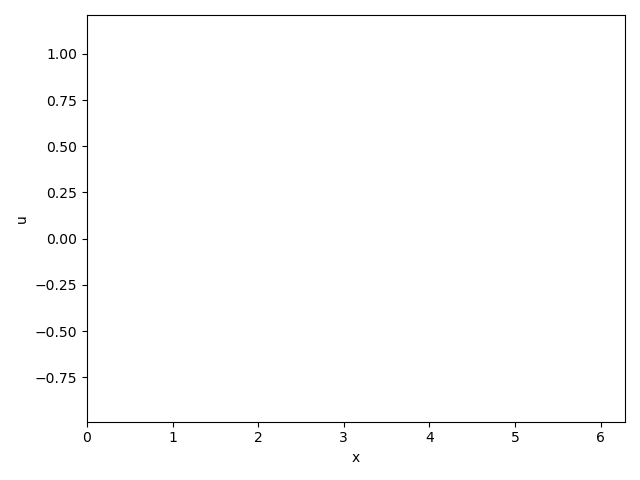

In [13]:
# model parameters
L = 2*np.pi   # domain length 

def c(x):     # wave speed
    return np.cos(x)

# numerical parameters
N = 500       # grid size

# set initial condition
x = np.linspace(0, L, N, endpoint=False)
f = 1/np.cosh((x-3*np.pi/2)*5)
f = 0.1+np.sin(x)

# animation parameters
Nsteps = 1800
Nskip = 10

# set time step to satisfy stability criterion (cfl<1)
cfl = 0.2
dx = L/N
dt = cfl * dx / np.max(np.abs(c(x)))
T = Nsteps*dt

# compute and animate solution
Nframes = int(Nsteps/Nskip)
U = np.zeros((Nframes, N))
C = dt * c(x) / dx

fig = plt.figure()
ax  = plt.axes(xlim=(0,L), ylim=(np.min(np.min(f)*1.1,0), np.max(np.max(f)*1.1,0)))
line1, = ax.plot([], [], linewidth=2, color = "tab:blue")
ax.set_xlabel('x')
ax.set_ylabel('u')
ani = animation.FuncAnimation(fig, update_graph,
                              update_solution(f, U, C, Nframes, Nskip),
                              fargs=(x, line1), interval=25, blit=False, repeat=False)
plt.tight_layout()
plt.show()

Finally, we visualize the solution in a space-time contour plot and plot several characteristic curves.

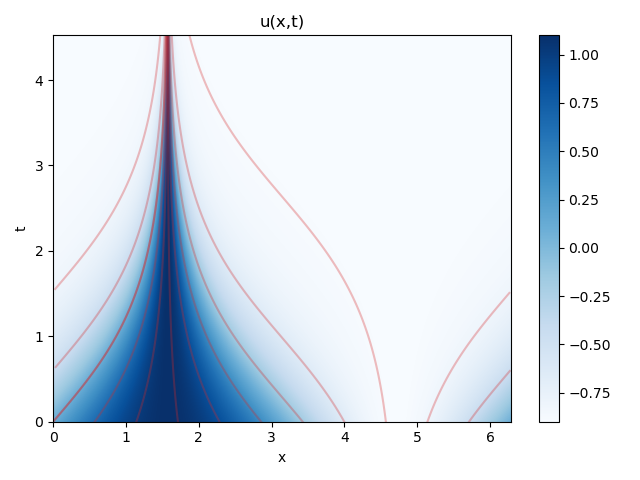

In [14]:
fig = plt.figure()
extent = [0, L, 0, T]
plt.imshow(U, cmap='Blues', interpolation='bilinear', extent=extent, aspect='auto', origin='lower')
for x0 in np.linspace(0, L, 12):
    soln = solve_ivp(lambda t, x: c(x), [0, T], [x0], t_eval=np.linspace(0, T, 100), atol=1.e-8, rtol=1.e-6)
    chars = np.vstack((np.mod(soln.y[0], L), soln.t))
    jumps = abs(np.diff(chars[0, :]))
    chars = np.insert(chars, 1+np.where(jumps>L/2)[0], np.NaN, axis=1)
    plt.plot(chars[0, :], chars[1, :], color='tab:red', alpha=0.3)
plt.title('u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.tight_layout()
plt.show()